In [120]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-83c9fc3d-a029-4989-8bc5-6a0013958323',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'n0G3snz0s4z1uLZXNLwgr2vTQziuMWQSjGNJMV6ACnR0'
}

configuration_name = 'os_fcadade136bb45d699bec52b7b8b350c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer, VectorAssembler, Normalizer
from pyspark.sql.functions import udf, asc, desc, countDistinct, avg, when, isnull, explode, col, \
array, lit, split, from_unixtime, dayofweek, hour
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml import Pipeline
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'udacityspark-donotdelete-pr-5ai936sox18kwj'))
# df_data_1.take(5)


In [121]:
# create a Spark session
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Capstone") \
    .getOrCreate()

In [122]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'udacityspark-donotdelete-pr-5ai936sox18kwj'))

In [123]:
#View the fields in the data frame
df.printSchema()

#Remove the 15,700 empty user ID's
df_filtered = df.where(df['userId'] != '')

#confirm that all records have at least one session Id
df_filtered.groupBy("userAgent").count().orderBy(asc("count")).show()

#Only keep the columns with the features that we will use
df_feature_columns = ['gender', 'length', 'level', 'location', 'method', 'page', 'sessionID', 'song', 'ts', 'userAgent', 'userId']

#create a new dataframe with only the relevant feature columns
df_churn_page = df_filtered.select(df_feature_columns).persist()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Mac...|  245|
|Mozilla/5.0 (comp...|  406|
|Mozilla/5.0 (Maci...|  447|
|"Mozilla/5.0 (X11...|  523|
|"Mozilla/5.0 (Mac...|  525|
|Mozilla/5.0 (Wind...|  542|
|Mozilla/5.0 (X11;...|  593|
|Mozilla/5.0 (W

In [124]:
df_churn_page.printSchema()

root
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionID: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [125]:
#Consider any "Cancellation Confirmation" or "Submit Downgrade" event to be a "Churn event"
df_churn_page = df_churn_page.withColumn('churn', when(df_churn_page['page'] == 'Cancellation Confirmation', 1).otherwise(0))
df_churn_page = df_churn_page.withColumn('churn', when(df_churn_page['page'] == 'Submit Downgrade', 1).otherwise(df_churn_page['churn']))
df_churn_page = df_churn_page.withColumn("churn", df_churn_page["churn"].cast(IntegerType()))

In [126]:
#Show the number of 'churned' users to 'non-churned' users
df_churn_page.groupby('churn').count().sort('count', ascending=[False]).show()

+-----+------+
|churn| count|
+-----+------+
|    0|527789|
|    1|   216|
+-----+------+



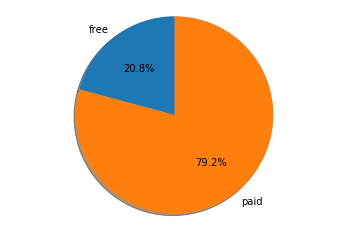

In [127]:
'''
level data analysis
'''

#Compare count of levels between free and paid users
level_df = df_filtered.groupBy("level").count().orderBy("level")
level_df_pandas = level_df.toPandas()

#plot the ratio of free users in blue to paid users in orange
fig1, ax1 = plt.subplots()
ax1.pie(level_df_pandas['count'],  labels=level_df_pandas['level'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

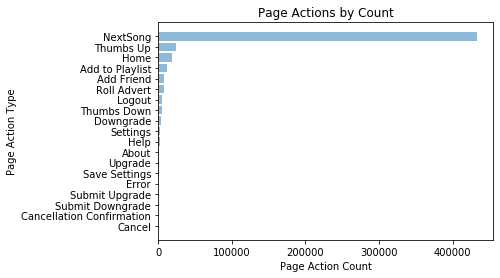

In [128]:
'''
page analysis
'''

#Define Page Events for users
events_page = df_filtered.groupBy("page").count().orderBy("page")
pandas_df = events_page.toPandas()
pandas_df = pandas_df.sort_values('count')

#Create Y-axis of Page Event NAmes
y_pos = np.arange(len(pandas_df['page']))
y_vals = pandas_df['count']

#Create barchart showing User Page Actions and Counts
plt.barh(y_pos, y_vals, align='center', alpha=0.5)
plt.yticks(y_pos, pandas_df['page'])

#Add label and title to Page actions
plt.xlabel('Page Action Count')
plt.ylabel('Page Action Type')
plt.title('Page Actions by Count')

#Create the barplot
plt.show()

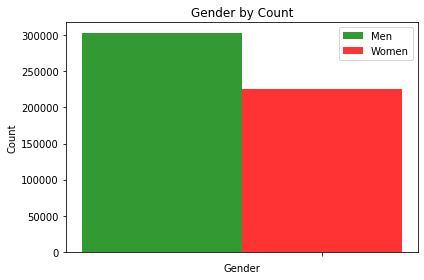

In [129]:
'''
gender analysis
'''

#Extract gender and transform into Pandas dataframe
gender_df = df_churn_page.groupBy("gender").count().orderBy("gender")
female_count = gender_df.where(gender_df['gender'] == 'F')
male_count = gender_df.where(gender_df['gender'] == 'M')
male_count_df = male_count.toPandas()
female_count_df = female_count.toPandas()

#Arrange genders into a number of groups
n_groups = 1
index = np.arange(n_groups)

#Create a barchart display the count of Male users in the Dataset
rects1 = plt.bar(index, male_count_df['count'], 0.35,
alpha=0.8,
color='g',
label='Men')

##Create a barchart display the count of Fele users in the Dataset
rects2 = plt.bar(index + .35, female_count_df['count'], 0.35,
alpha=0.8,
color='r',
label='Women')

#Add labels to the barchart
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender by Count')
plt.xticks(index + .35, ('', 'Men', 'Women'))
plt.legend()

#Plot the two ratios of the gender next to eachother
plt.tight_layout()
plt.show()

In [130]:
'''
Timestamp Analysis
'''

#Convert the UNIX timetamp into human readable seconds, hours, and days
df_churn_page = df_churn_page.withColumn('ts_seconds', from_unixtime(col('ts') / 1000))
df_churn_page = df_churn_page.withColumn('ts_hours', hour(col('ts_seconds')))
df_churn_page = df_churn_page.withColumn('ts_day', dayofweek(col('ts_seconds')))

In [131]:
#Cast the timestamp into a Pandas dataframe
user_times = df_churn_page.groupBy("ts").count().orderBy("ts")
pandas_time_df = user_times.toPandas()

pandas_time_df["ts"]= pandas_time_df["ts"].astype(str) 
pandas_time_df["ts"]= pandas_time_df["ts"].str.slice(0, 10, 1) 
pandas_time_df["ts"]= pandas_time_df["ts"].astype(int) 

ts_date_values = []
ts_time_values = []
ts_day_values = []

import datetime
from dateutil import parser

#Use numpy to extract the Year-Month-Day, hour-minute-second, and day of the week values for each record 
for val in pandas_time_df["ts"].astype(int).values:
    val_dates = datetime.datetime.fromtimestamp(val)
    ts_date_values.append(str(val_dates.year) + "-" + str(val_dates.month) + "-" + str(val_dates.day))
    ts_time_values.append(str(val_dates.hour) + "-" + str(val_dates.minute) + "-" + str(val_dates.second))
    ts_day_values.append(parser.parse(str(str(val_dates.year) + "-" + str(val_dates.month) + "-" + str(val_dates.day))).strftime('%a'))

#create a dataframe for each time value
ts_dates_df = pd.DataFrame(ts_date_values)
ts_times_df = pd.DataFrame(ts_time_values)
ts_days_df = pd.DataFrame(ts_day_values)

pandas_time_df["ts_date"] = ts_dates_df
pandas_time_df["ts_time"] = ts_times_df
pandas_time_df["ts_day"] = ts_days_df

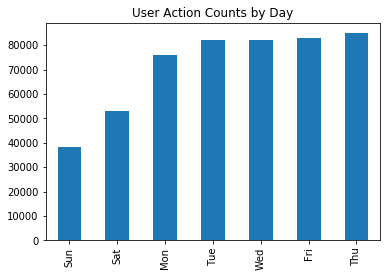

In [132]:
#Extract the day of the week from each timestamp record
pandas_time_df['ts_time_formatted'] = pd.to_datetime(pandas_time_df['ts_time'], format='%H-%M-%S')
pandas_time_df['ts_hour'] = pandas_time_df['ts_time_formatted'].dt.hour

#Plot the count of each record onto a barchart, binned by the day of the week for each record
ts_counts = pandas_time_df['ts_day'].value_counts(sort=True, ascending=True)

ts_counts.plot(kind="bar", title="User Action Counts by Day")

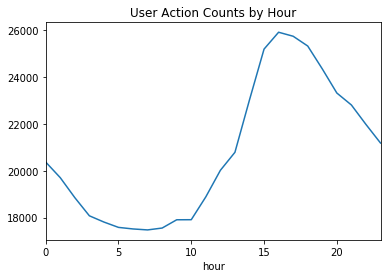

In [133]:
#Extract the hour of the day from each timestamp record
ts_hour_counts = pandas_time_df['ts_hour'].value_counts()
ts_hour_counts_df = pd.DataFrame({'hour':ts_hour_counts.index, 'count':ts_hour_counts.values}).sort_values(by=['hour'])

#Plot the hour of each record onto a linechart
ts_hour_counts_df
ts_hour_counts_df.set_index('hour')['count'].plot(title="User Action Counts by Hour");

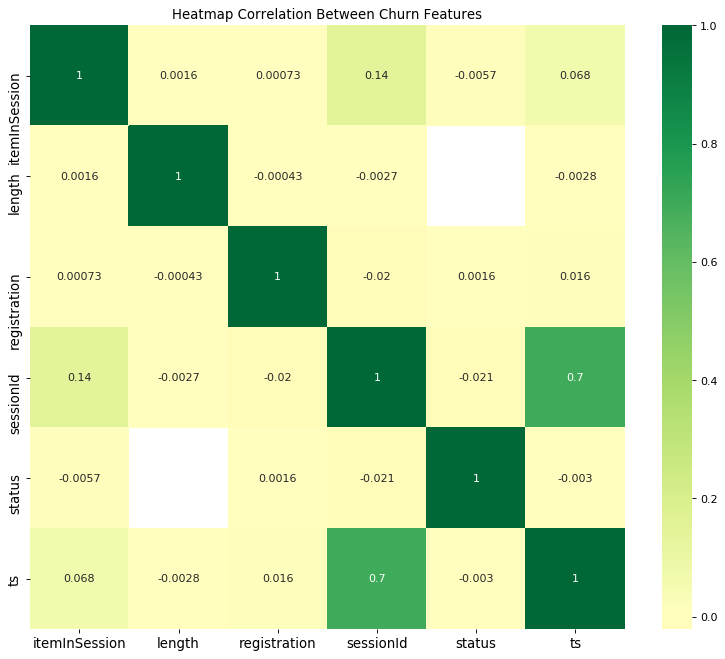

In [134]:
'''
Correlation Analysis
'''


df_filtered_pandas = df_filtered.toPandas()


plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_filtered_pandas.corr(), xticklabels=df_filtered_pandas.corr().columns, yticklabels=df_filtered_pandas.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Heatmap Correlation Between Churn Features')
plt.show()


In [135]:
'''
Balance Dataset
'''

#The basic process to use up-samplling to create a balanced dataset was derived from this blog: 
#https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

#Categorize records into 0 for users that are not part of a churn event and 1 for users that are part of a churn event
no_churn = df_churn_page.where(df_churn_page["churn"] == 0)
yes_churn = df_churn_page.where(df_churn_page["churn"] == 1)

#Count chured and non-churned users
no_churn_count = no_churn.count()
yes_churn_count = yes_churn.count()

#Examine the ratio of churn users to non-churn users
ratio = int(no_churn_count/yes_churn_count)
print("ratio: {}".format(ratio))

#Create a range from 0 to the number of records in the ratio of churned users to non-churned users
churn_range = range(ratio)

ratio: 2443


In [136]:
#Use the explode function to create a duplicate record for every users without a churn event to obtain an equal 
#sample to the non-churn users
oversampled_churn = yes_churn.withColumn("dummy", explode(array([lit(x) for x in churn_range]))).drop('dummy')

In [137]:
# combine both oversampled rows and user churn records 
df_churn_page = no_churn.unionAll(oversampled_churn)

In [138]:
#Cast the churn column into a String Index Label
churn_page_index = StringIndexer(inputCol="churn", outputCol="label")

#fit and transform the String Indexer into a normal distribution
df_churn_page = churn_page_index.fit(df_churn_page).transform(df_churn_page)

#drop the churn label from the original dataframe
df_churn_page = df_churn_page.drop('churn')

In [139]:
#Cast the gender column into a String Index Label
gender_index = StringIndexer(inputCol="gender", outputCol="gender_index")

#fit and transform the Gender Indexer into a normal distribution
df_churn_page = gender_index.fit(df_churn_page).transform(df_churn_page)

#drop the gender label from the original dataframe
df_churn_page = df_churn_page.drop('gender')

In [140]:
#Cast the level column into a String Index Label
level_index = StringIndexer(inputCol="level", outputCol="level_index")

#fit and transform the Level Indexer into a normal distribution
df_churn_page = level_index.fit(df_churn_page).transform(df_churn_page)

#drop the level label from the original dataframe
df_churn_page = df_churn_page.drop('level')

In [141]:
#Filter out any records without a user ID and view the location of each user
df_churn_page = df_churn_page.where(df_churn_page['userId'] != '')
df_churn_page.groupBy("location").count().orderBy(desc("count")).show()

#Extract the City and State from each record and add it as a column
df_churn_page = df_churn_page.withColumn('state', split(df_churn_page['location'], ',').getItem(1))

#drop the location label from the original dataframe
df_churn_page = df_churn_page.drop('location')

+--------------------+-----+
|            location|count|
+--------------------+-----+
|New York-Newark-J...|88996|
|Los Angeles-Long ...|78234|
|Chicago-Napervill...|39614|
|Dallas-Fort Worth...|30597|
|Atlanta-Sandy Spr...|25863|
|Boston-Cambridge-...|24900|
|San Francisco-Oak...|23638|
|Philadelphia-Camd...|19172|
|Phoenix-Mesa-Scot...|16068|
|Houston-The Woodl...|16033|
|Tampa-St. Petersb...|15656|
|Louisville/Jeffer...|14783|
|Washington-Arling...|13507|
|Miami-Fort Lauder...|13064|
|Orlando-Kissimmee...|12619|
|Minneapolis-St. P...|12346|
|Denver-Aurora-Lak...|12250|
|Austin-Round Rock...|12133|
|  Kansas City, MO-KS|11840|
|       Knoxville, TN|10562|
+--------------------+-----+
only showing top 20 rows



In [142]:
#Filter out any records without a user ID and view the userAgent of each user
df_churn_page = df_churn_page.where(df_churn_page['userId'] != '')
df_churn_page.groupBy("userAgent").count().orderBy(desc("count")).show()

#Cast the userAgent column into a String Index Label
user_agent_index = StringIndexer(inputCol="userAgent", outputCol="userAgent_index")

#fit and transform the userAgent Indexer into a normal distribution
df_churn_page = user_agent_index.fit(df_churn_page).transform(df_churn_page)

#drop the userAgent label from the original dataframe
df_churn_page = df_churn_page.drop('userAgent')

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|Mozilla/5.0 (Wind...|88296|
|"Mozilla/5.0 (Mac...|85154|
|"Mozilla/5.0 (Win...|65413|
|"Mozilla/5.0 (Win...|63448|
|"Mozilla/5.0 (Mac...|53661|
|"Mozilla/5.0 (Mac...|53631|
|Mozilla/5.0 (Maci...|40557|
|"Mozilla/5.0 (Mac...|34612|
|"Mozilla/5.0 (Win...|33886|
|"Mozilla/5.0 (Mac...|33036|
|"Mozilla/5.0 (iPh...|32415|
|"Mozilla/5.0 (Win...|28136|
|Mozilla/5.0 (Wind...|24805|
|"Mozilla/5.0 (Win...|20297|
|Mozilla/5.0 (Wind...|20200|
|"Mozilla/5.0 (Win...|20108|
|"Mozilla/5.0 (iPa...|19254|
|"Mozilla/5.0 (Win...|17693|
|Mozilla/5.0 (Wind...|17061|
|"Mozilla/5.0 (iPh...|16893|
+--------------------+-----+
only showing top 20 rows



In [143]:
#Count the number of records from the 'Save Settings' page and add it as a new column
df_churn_page_saved = df_churn_page.select('userId', 'page')\
        .where('page = "Save Settings"')\
        .groupby('userId').count()\
       .withColumnRenamed('count', 'saved_settings')

#Join the saved_settings record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_saved, 'userId', 'inner')

In [144]:
#Count the number of records from the 'Save Settings' page and add it as a new column
df_churn_page_num_songs = df_churn_page.select('userId', 'song')\
        .groupby('userId').count()\
       .withColumnRenamed('count', 'num_songs')

#Join the saved_settings record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_num_songs, 'userId', 'inner')

In [145]:
#Count the number of records from the 'Thumb Down' page and add it as a new column
df_churn_page_down = df_churn_page.select('userId', 'page')\
        .where('page = "Thumbs Down"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_down')

#Join the thumbs_down record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_down, 'userId', 'inner')

In [146]:
#Count the number of records from the 'Thumb Down' page and add it as a new column
df_churn_page_up = df_churn_page.select('userId', 'page')\
        .where('page = "Thumbs Up"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'thumbs_up')

#Join the thumbs_down record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_up, 'userId', 'inner')

In [147]:
#Count the number of records from the 'Add to Playlist' page and add it as a new column
df_churn_page_add = df_churn_page.select('userId', 'page')\
        .where('page = "Add to Playlist"')\
        .groupby('userId').count()\
        .withColumnRenamed('count', 'playlist_added')

#Join the playlist_added record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_add, 'userId', 'inner')

In [148]:
#Count the average count of songs a user listened to per single session and add it as a new column
df_churn_page_add = df_churn_page.where('page == "NextSong"') \
        .groupby(['userId', 'sessionID']) \
        .count() \
        .groupby(['userId']) \
        .agg({'count':'avg'}) \
        .withColumnRenamed('avg(count)', 'songs_per_session')

#Join the songs_per_session record to the original dataframe using an inner-join on the userId column
df_churn_page = df_churn_page.join(df_churn_page_add, 'userId', 'inner')

In [149]:
#Drop all of the columns that are no longer needed in the dataframe
df_churn_page = df_churn_page.drop(*['gender', 'length', 'level', 'location', 'method', 'page', 'sessionID', 'song', 'ts', 'userAgent', 'userId'])

In [150]:
#Identify the relevant columns to be used in the classification model
feature_columns = ['gender_index', 'level_index', 'userAgent_index',  'ts_day', 
                    'saved_settings', 'num_songs', 'thumbs_up', 
                   'thumbs_down', 'playlist_added',  'songs_per_session']

In [151]:
#review the dataframe to confirm that all of the relevant rows were removed
df_churn_page.show()

+-------------------+--------+------+-----+------------+-----------+-----+---------------+--------------+---------+-----------+---------+--------------+-----------------+
|         ts_seconds|ts_hours|ts_day|label|gender_index|level_index|state|userAgent_index|saved_settings|num_songs|thumbs_down|thumbs_up|playlist_added|songs_per_session|
+-------------------+--------+------+-----+------------+-----------+-----+---------------+--------------+---------+-----------+---------+--------------+-----------------+
|2018-10-01 15:17:10|      15|     2|  0.0|         1.0|        0.0|   NJ|            4.0|             3|     4598|         15|      102|            45|          114.125|
|2018-10-01 15:17:32|      15|     2|  0.0|         1.0|        0.0|   NJ|            4.0|             3|     4598|         15|      102|            45|          114.125|
|2018-10-01 15:23:00|      15|     2|  0.0|         1.0|        0.0|   NJ|            4.0|             3|     4598|         15|      102|        

In [152]:
#Use a Vector Assembler to 'Vectorize' the features of the model
df_churn_assembler = VectorAssembler(inputCols=feature_columns, outputCol='churn_vector_features')

#Transform the result set to prepare vectorized data for normalization
df_churn_page = df_churn_assembler.transform(df_churn_page)

In [153]:
#Normalize the vectorized data to create a normal distribution of values
df_churn_normalizer = Normalizer(inputCol='churn_vector_features', outputCol='features')
df_churn_page = df_churn_normalizer.transform(df_churn_page)

In [154]:
#Create a random seed for a classification model
seed = 2342
            
#Create an empty instance of a Multi Class Evaluator Model with a single label
df_churn_evaluator = MulticlassClassificationEvaluator(labelCol='label')

In [155]:
#Break the dataframe up into 80%  training and 20% testing datasets, randomly seeded
train, test = df_churn_page.randomSplit([0.8, 0.2], seed=seed)

In [118]:
#Create an empty GBT Classifer with a target named 'label' and seed it
gbt_classifier = GBTClassifier(labelCol='label', maxDepth=2, seed=seed)

#Fit the training data using the classifier
gbt_model = gbt_classifier.fit(train)

#Test trained classifier against the held-out test data
gbt_predictions = gbt_model.transform(test)

KeyboardInterrupt: 

In [70]:
#Display the F1, Weighted Precision, Weighted Accuracy, and Raw Accuracy of the GBT Classifier
evaluation_metrics(df_churn_evaluator, gbt_predictions)

F1:	0.8031191515907673
WP:	0.8220411634448643
WR:	0.8031191515907673
Accu:	0.8031191515907673


In [156]:
#Create an empty instance of a GBT Classifier with a single label, randomly seeded
df_churn_gbt = GBTClassifier(labelCol='label', seed=seed)

#create a Parameter Grid 
paramGrid = ParamGridBuilder() \
                    .addGrid(df_churn_gbt.maxBins, [4]) \
                    .addGrid(df_churn_gbt.maxDepth, [1, 2]) \
                    .addGrid(df_churn_gbt.maxIter, [1]) \
                    .build()



In [157]:
#Create a pipeline
df_churn_pipeline = Pipeline(stages=[df_churn_gbt])

In [158]:
#Create a crossfold validation model to input the pipeline and evaluate th
df_churn_cv = CrossValidator(estimator=df_churn_pipeline, evaluator=df_churn_evaluator, 
                    estimatorParamMaps=paramGrid, numFolds=5)

In [159]:
#Input Training Data into Cross Validator
df_churn_best_model = df_churn_cv.fit(train)

In [162]:
def evaluation_metrics(evaluation_metric, predictions):
    """Receives a model's evaluator and predictions dataframe and calculates 
    f-1, weighted precision, weighted recall and accuracy and prints them
    out.
    Args:
    evaluator:
        The evaluator used to calculate model metrics.
    predictor:
        The predictions dataframe used to calculate precission and recall.
    Returns:
        Nothing
    """
    f1_score = evaluation_metric.evaluate(predictions)
    weighted_precision = evaluation_metric.setMetricName("weightedPrecision").evaluate(predictions)
    weighted_recall = evaluation_metric.setMetricName("weightedRecall").evaluate(predictions)
    accuracy = evaluation_metric.setMetricName("accuracy").evaluate(predictions)
    
    print("F1:\t{}\nWP:\t{}\nWR:\t{}\nAccu:\t{}".format(f1_score, weighted_precision, weighted_recall, accuracy))

In [166]:
def confusion_matrix(predictor):
    """Receives a model's predictions dataframe and calculates the 
    precission and recall. Also prints out the true and false positive/negative
    values.
    Args:
    predictor:
        The predictions dataframe used to calculate precission and recall.
    Returns:
        Nothing
    """
    true_negative = predictor.select("*").where("prediction = 0 AND label = 0").count()
    true_positive = predictor.select("*").where("prediction = 1 AND label = 1").count()
    
    false_negative = predictor.select("*").where("prediction = 0 AND label = 1").count()
    false_positive = predictor.select("*").where("prediction = 1 AND label = 0").count()
    
    if (true_positive + false_positive) != 0:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
    else:
        precision = 0
        recall = 0
        
    print("True Negative: {}\nTrue Positive: {}".format(true_negative, true_positive))
    print("False Negative: {}\nFalse Positive: {}".format(false_negative, false_positive))
    print("Precission: {}\nRecall: {}".format(precision, recall))

In [61]:
#Create an empty Logictic Regression Model
logistic_regression_model = LogisticRegression()

#Fit the training data in the Logistic Regression Model to a normal distribution
logistic_regression_model_fit = logistic_regression_model.fit(train)

#Test trained model against the held-out test data
logistic_regression_model_predictions = logistic_regression_model_fit.transform(test)

In [ ]:
#Display the F1, Weighted Precision, Weighted Accuracy, and Raw Accuracy of the Regression Classfier
evaluation_metrics(df_churn_evaluator, logistic_regression_model_predictions)

F1:	0.5766687461010606
WP:	0.3325468427297694
WR:	0.5766687461010606
Accu:	0.5766687461010606


In [59]:
#Create an empty Random Forest Model and seed it
random_forest_classifier = RandomForestClassifier(featureSubsetStrategy='auto', maxDepth=2, seed=seed)

#Fit the training data in the Random Forest Model to a normal distribution
random_forest_model = random_forest_classifier.fit(train)

#Test trained model against the held-out test data
random_forest_predictions = random_forest_model.transform(test)

In [ ]:
#Display the F1, Weighted Precision, Weighted Accuracy, and Raw Accuracy of the RF Classifier
evaluation_metrics(df_churn_evaluator, random_forest_predictions)

F1:	0.7645730543229536
WP:	0.7907241003866798
WR:	0.7638112749121713
Accu:	0.7638112749121713


In [62]:
#Create an empty Naive Bayes Classifier
naive_bayes_classifier = NaiveBayes()

#Fit the training data in the Naive Bayes Model to a normal distribution
naive_bayes_model = naive_bayes_classifier.fit(train)

#Test trained model against the held-out test data
naive_bayes_predictions = naive_bayes_model.transform(test)

In [65]:
#Display the F1, Weighted Precision, Weighted Accuracy, and Raw Accuracy of the NB Classifier
evaluation_metrics(df_churn_evaluator, naive_bayes_predictions)

F1:	0.5766687461010606
WP:	0.3325468427297694
WR:	0.5766687461010606
Accu:	0.5766687461010606


In [160]:
#Input transformed Test Data into Cross Validator
df_churn_predictions = df_churn_best_model.transform(test)

#Show the schema of the outputted prediction data frame
df_churn_predictions.printSchema()

root
 |-- ts_seconds: string (nullable = true)
 |-- ts_hours: integer (nullable = true)
 |-- ts_day: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- gender_index: double (nullable = false)
 |-- level_index: double (nullable = false)
 |-- state: string (nullable = true)
 |-- userAgent_index: double (nullable = false)
 |-- saved_settings: long (nullable = false)
 |-- num_songs: long (nullable = false)
 |-- thumbs_down: long (nullable = false)
 |-- thumbs_up: long (nullable = false)
 |-- playlist_added: long (nullable = false)
 |-- songs_per_session: double (nullable = true)
 |-- churn_vector_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [163]:
#Run the evaluator and predictions through a function to output the models descriptive statistics
evaluation_metrics(df_churn_evaluator, df_churn_predictions)

F1:	0.7771021048639821
WP:	0.7770310063497011
WR:	0.7771809436254391
Accu:	0.7771809436254391


In [164]:
#Review a snapshot of the raw predictions for each record in the prediction dataset
df_churn_predictions.select("RawPrediction","prediction") \
.orderBy("RawPrediction", ascending=True) \
.show(25, False)

+--------------------------------------+----------+
|RawPrediction                         |prediction|
+--------------------------------------+----------+
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.476260908149682,0.476260908149682]|1.0       |
|[-0.4762609

In [ ]:
#Create a confusion matrix to show the descriptive statistics
confusion_matrix(df_churn_predictions)

In [47]:
#Examine the importance of each feature in the GBT model
df_churn_best_model.bestModel.stages[0].featureImportances

#Examine a map of the Parameters used in the GBT model
df_churn_best_model.bestModel.stages[0].extractParamMap()

{Param(parent='GBTClassifier_5d6fd58aa9e0', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_5d6fd58aa9e0', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_5d6fd58aa9e0', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_5d6fd58aa9e0', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_5d6fd58aa9e0', name='labelCol', doc='label column name'): 'la

In [48]:
#Display the count of 'True Negatives',  the number of correct no-churn predictions
true_negative = df_churn_predictions.select("*").where("prediction = 0 AND label = 0").count()

In [49]:
true_negative

71021

In [50]:
#Display the count of 'True Positives',  the number of correct churn predictions
true_positive = df_churn_predictions.select("*").where("prediction = 1 AND label = 1").count()

In [51]:
true_positive

47332

In [52]:
print("True Negative: {}\nTrue Positive: {}".format(true_negative, true_positive))

True Negative: 71021
True Positive: 47332


In [53]:
#Display the count of 'False Negatives',  the number of incorrect no-churn predictions
false_negative = df_churn_predictions.select("*").where("prediction = 0 AND label = 1").count()

In [ ]:
false_negative

In [54]:
#Display the count of 'False Positives',  the number of incorrect churn predictions
false_positive = df_churn_predictions.select("*").where("prediction = 1 AND label = 0").count()

In [ ]:
false_positive

In [55]:
print("False Negative: {}\nFalse Positive: {}".format(false_negative, false_positive))

False Negative: 17135
False Positive: 16797
